In [1]:
import xarray as xr
import rioxarray
import pandas as pd
import geopandas as gpd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from einops import rearrange
from tqdm import tqdm
from shapely import box
from geocube.api.core import make_geocube


import cv2

root = Path.cwd()

In [ ]:
o

In [5]:
class DataStack():
    """Class containing processed data for input into minimum noise fraction functions"""
    def __init__(self,root,version,year,site_name,epsg):
        self.root = root
        os.makedirs(self.root / 'sentinel_data' / version,exist_ok=True)
        self.folder = version
        self.year = year
        self.site_name = site_name
        self.epsg = int(epsg)

        b = xr.open_dataarray(self.root / 'sentinel_data' / f'{self.year}_{self.site_name}.nc')
        self.input_data = b.rio.write_crs(self.epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

        self.season_data = None

        f1 = self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_aligned_bands.nc'
        if os.path.isfile(f1):
            self.aligned_bands = xr.open_dataarray(f1)
        else:
            self.aligned_bands = None 

        f2 = self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_variables.nc'
        if os.path.isfile(f2):
            self.all_variables = xr.open_dataarray(f2)
        else:
            self.all_variables = None
        
        f3 = self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_pca.nc'
        if os.path.isfile(f3):
            self.pca = xr.open_dataarray(f3)
        else:
            self.pca = None
        
        f4 = self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_diffs.nc'
        if os.path.isfile(f4):
            self.diffs = xr.open_dataarray(f4)
        else:
            self.diffs = None

    def plot_input_data(self,band):
        self.input_data.isel(band=band).plot(col='time',col_wrap=4,robust=True)

    def plot_season_data(self,band):
        if self.season_data is not None:
            self.season_data.isel(band=band).plot(col='time',col_wrap=4,robust=True)
        else:
            print('need to run method: select_season_data()')
    
    def plot_aligned_data(self,band):
        if self.aligned_data is not None:
            self.aligned_data.isel(band=band).plot(col='time',col_wrap=4,robust=True)
        else:
            print('need to run method: coregister_data()')
    
    def select_season_data(self,date_list): # input date_list based on manual inspection of input data
        e = [str(x) for x in self.input_data.time.values if any(date in str(x) for date in date_list)]
        self.season_data =  self.input_data.sel(time=e)
    
    def get_gradient(self,im) :
        # Calculate the x and y gradients using Sobel operator
        grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
        grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
        # Combine the two gradients
        grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)

        return grad
    
    def coregister_data(self):
    
        # replace nas with 0
        b_sel = self.season_data.where(~np.isnan(self.season_data), other=0)
        # create reference image: mean of all temporal steps
        reference_image = self.season_data.mean(dim=['band','time'])
        # replace na with 0 
        reference_image = reference_image.where(~np.isnan(reference_image), other=0)

        # convert input data to numpy float32 numpy arrays
        reference_image = np.float32(reference_image.to_numpy())
        im = np.float32(b_sel.to_numpy())

        # define dimensions for output image
        height = b_sel.shape[2]
        width = b_sel.shape[3]
        time = b_sel.shape[0]
        band = b_sel.shape[1]

        ## Define motion model
        warp_mode = cv2.MOTION_AFFINE
        # Set the warp matrix to identity matrix
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        # Set the stopping criteria for the algorithm.
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)

        # Create empty array of correct size for new aligned images
        im_aligned = np.zeros((time,band,height,width), dtype=np.float32 )

        # loop over time and band dimensions and apply coregistration to each band
        for i in range(0,time):
            for j in tqdm(range(0,band)) :
                (_, warp_matrix) = cv2.findTransformECC(self.get_gradient(reference_image), self.get_gradient(im[i,j,:,:]),warp_matrix, warp_mode, criteria)    
                                                                       
                im_aligned[i,j,:,:] = cv2.warpAffine(im[i,j,:,:], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

        b_align = xr.DataArray(im_aligned, 
                      coords={'time':b_sel.time,'band': b_sel.band,'y': b_sel.y,'x':b_sel.x}, 
                      dims=['time','band','y','x'])
        b_align = b_align.where(b_align!=0, other=np.nan) # reset 0 values to na
    

        self.aligned_data = b_align
        b_align.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_aligned_bands.nc')
        print(f'coregisterd bands saves to {self.root} / sentinel_data / {self.folder} / {self.year}_{self.site_name}_aligned_bands.nc')

    
    def remove_outliers(self,a,norm=True):
        a = a.where(np.isfinite(a),np.nan)
        if norm == True:
            a = a.where((a >= -1) & (a <= 1))
        else:
            a = a.where((a >= 0) & (a <= 8))
        return a
    
    
    def add_all_variables(self,num_months,num_of_peak_evi_month): # number of months
        if self.aligned_data is None:
            print('need to run method: coregister_data()')
        else:
        # separate all bands onto 1 dimension
            t = np.arange(0,num_months)
            season_list = [f'month{x}' for x in t]

            array_list1 = list()
            for i, season in enumerate(season_list):
                t = self.aligned_data.isel(time=i).reset_coords('time',drop=True)
                t = t.assign_coords({'band':[f'{x}_{season}' for x in self.aligned_data.band.values]})
                array_list1.append(t)

            m1 = xr.concat(array_list1,dim='band')

            # calculate evi, lswi, slavi, psri for each season 
            #season_list = ['month1','month2','month3', etc....]
            array_list2 = list()
            for i in range(0,3):
                blue = array_list1[i].sel(band=f'B02_{season_list[i]}')
                green = array_list1[i].sel(band=f'B03_{season_list[i]}')
                red = array_list1[i].sel(band=f'B04_{season_list[i]}')
                nir = array_list1[i].sel(band=f'B8A_{season_list[i]}')
                sw1 = array_list1[i].sel(band=f'B11_{season_list[i]}')
                sw2 = array_list1[i].sel(band=f'B12_{season_list[i]}')
                re2 = array_list1[i].sel(band=f'B06_{season_list[i]}')


                evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1)).expand_dims({'band':[f'evi_{season_list[i]}']}) # range -1 - 1
                evi = self.remove_outliers(evi)

                lswi = (nir - sw1)/(nir + sw1).expand_dims({'band':[f'lswi_{season_list[i]}']}) # range -1 to 1
                lswi = self.remove_outliers(lswi)

                slavi = nir/(red + sw2).expand_dims({'band':[f'slavi_{season_list[i]}']}) # range 0 - 8
                slavi = self.remove_outliers(slavi,norm=False)

                psri = (red - blue)/re2.expand_dims({'band':[f'psri_{season_list[i]}']}) # range -1 to 1
                psri = self.remove_outliers(psri)

                bright = (0.3510*blue)+(0.3813*green)+(0.3437*red)+(0.7196*nir)+(0.2396*sw1)+(0.1949*sw2).expand_dims({'band':[f'bright_{season_list[i]}']})
                bright = self.remove_outliers(bright)

                wet = (0.2578*blue)+(0.2305*green)+(0.0883*red)+(0.1071*nir)+(-0.7611*sw1)+(-0.5308*sw2).expand_dims({'band':[f'wet_{season_list[i]}']})
                wet = self.remove_outliers(wet)

                green = (-0.3599*blue)+(-0.3533*green)+(-0.4734*red)+(0.6633*nir)+(0.0087*sw1)+(-0.2856*sw2).expand_dims({'band':[f'green_{season_list[i]}']})
                green = self.remove_outliers(green)

                season_vi = xr.concat([evi,lswi,slavi,psri,bright,wet,green],dim='band')

                array_list2.append(season_vi)

            m2 = xr.concat(array_list2,dim='band')

            m3 = xr.concat([m1,m2],dim='band')

            ## mask non-forest pixels
            self.all_variables = m3.where(m3.sel(band=f'evi_month{num_of_peak_evi_month}')>0.5,other=np.nan)
            # save
            self.all_variables.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_variables.nc')
            print(f'variables saved to {self.root}/sentinel_data/{self.folder}/{self.year}_{self.site_name}_variables.nc')



    # calculate differences for indices of given two months
    def get_season_differences(self,first,second):
        array_list = list()
        for vi in ['evi', 'lswi', 'slavi','psri','wet','bright','green']:
            d = self.all_variables.sel(band=f'{vi}_{first}') - self.all_variables.sel(band=f'{vi}_{second}')
            d = d.expand_dims({'band':[f'{vi}_{first}_{second}_diff']})
            array_list.append(d)
        
        self.diffs = xr.concat(array_list,dim='band')
        self.diffs.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_diffs.nc')
        print(f'diffs saved to {self.root}/sentinel_data/{self.folder}/{self.year}_{self.site_name}_diffs.nc')


    def run_pca(self,n,save=False):
        
        a = self.all_variables.values  # just indices, not diffs included in self.all_variables

        a_2d = rearrange(a, 'c h w -> (h w) c')
        # drop all na from data
        a2d_dropna = a_2d[~np.isnan(a_2d).any(axis=1)]
        # get indices of dropped nas to replace them later
        na_indices = np.where(np.isnan(a_2d))
        row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

        # rescale data around approximate mean of 0
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(a2d_dropna)

        
        pca = PCA(n_components=n)
        pca.fit(data_scaled)
        pca_data = pca.transform(data_scaled)
        print(f'explained variance: {pca.explained_variance_ratio_}')
        
            
        # replace nans that were dropped earlier
        output_array = np.full((a_2d.shape[0],pca_data.shape[1]), np.nan)  # create array of correct shape

        # Fill in the rows that were not NaN
        non_nan_indices = np.setdiff1d(np.arange(a_2d.shape[0]), row_indices)  # get indices that don't have na values
        output_array[non_nan_indices] = pca_data

        # # reshape to original dimensions
        height = self.all_variables.shape[1]
        width = self.all_variables.shape[2]
        new_pca_data = rearrange(output_array, '(h w) c -> c h w', h=height, w=width)
        pca_array = xr.DataArray(new_pca_data, 
                            coords={'band': np.arange(0,n),'y': self.all_variables.y,'x': self.all_variables.x}, 
                            dims=['band','y','x'])
        # todo: return object with explained variance, plot function etc.
        self.pca = pca_array
        if save is True:
            self.pca.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_pca.nc')
            print(f'pca saved to {self.root}/sentinel_data/{self.folder}/{self.year}_{self.site_name}_pca.nc')


    def plot_pca(self,rows,n_comps):
        fig = plt.subplots(figsize=(20,5))
        for i in range(0,n_comps):
            plt.subplot(rows, n_comps, i+1)
            self.pca.isel(band=i).plot()
        plt.show()
           



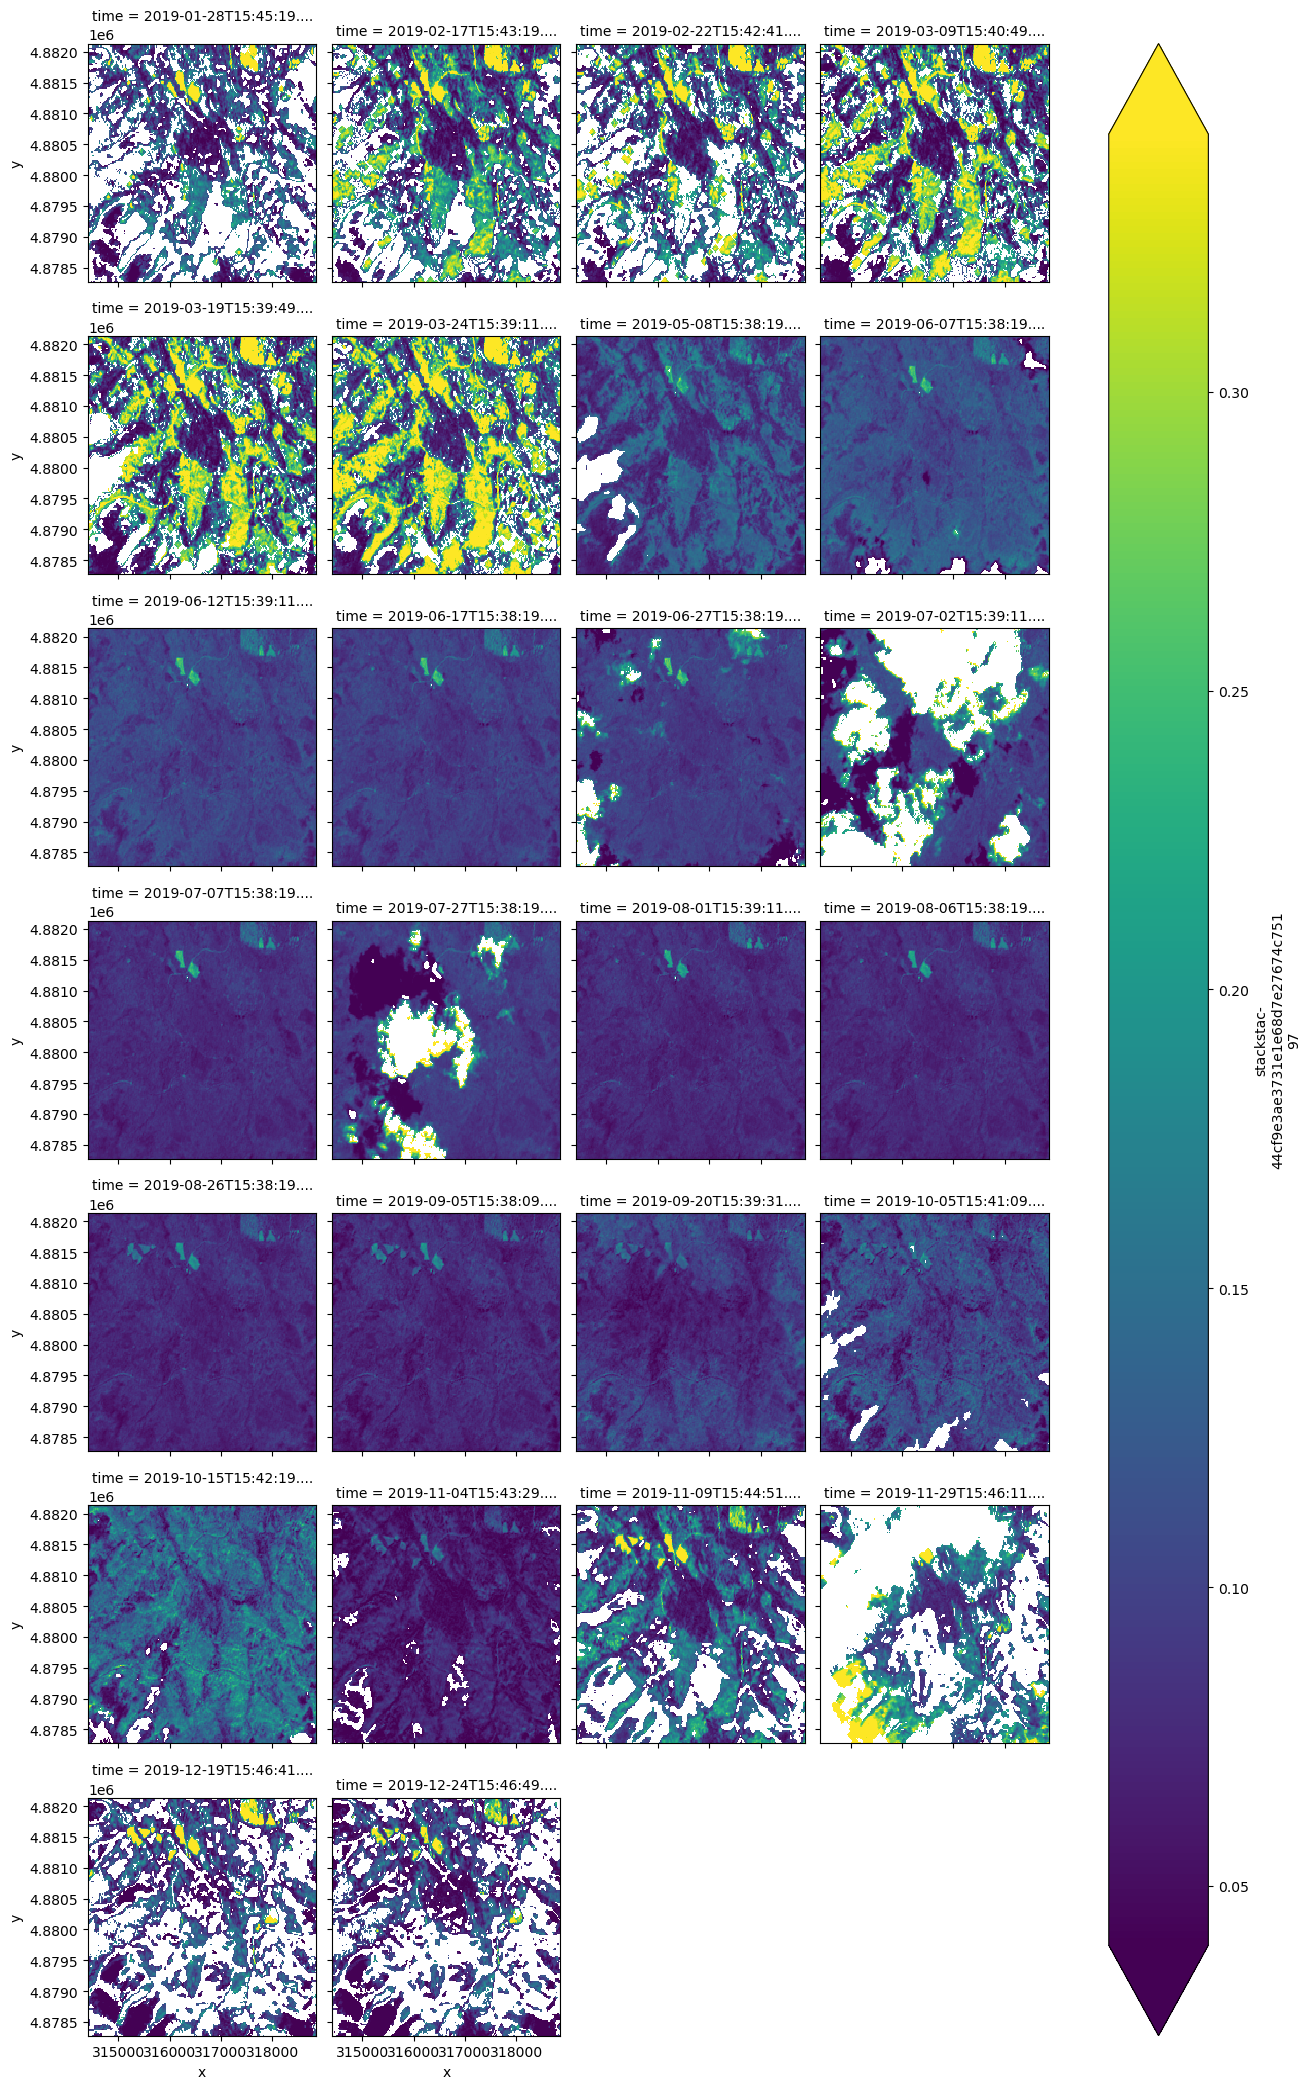

In [ ]:
roi1 = DataStack(root,'bart_growing_season',2019,'bart',26919)

roi1.plot_input_data(band=3)

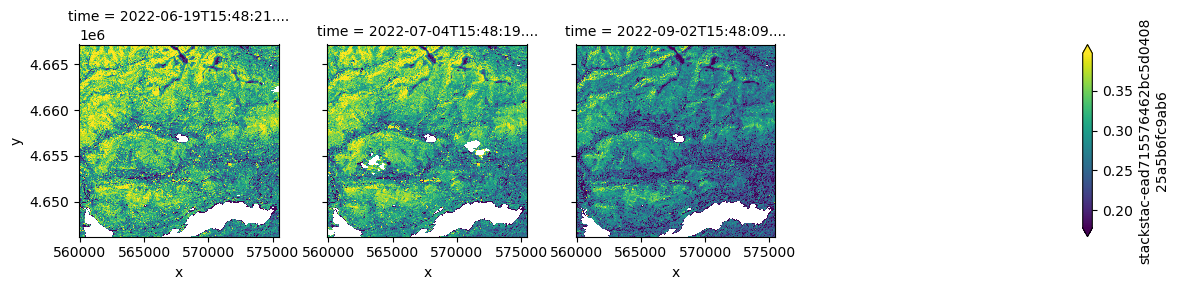

In [5]:
roi.select_season_data(date_list=['06-19','07-04','09-02'])
roi.plot_season_data()

In [6]:
roi.coregister_data()

100%|██████████| 10/10 [1:40:59<00:00, 605.96s/it]


In [7]:
roi.add_all_variables()

variables saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/2022_ashoken_variables.nc


In [8]:
roi.run_pca()

pca saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/2022_ashoken_pca.nc


In [23]:
# check pca output
for i in range(0,3):
    band = roi.pca.isel(band=i)
    print(f'{i}: {np.nanmin(band)} - {np.nanmax(band)}, mean: {np.nanmean(band)}')

0: -69.58165740966797 - 11.718316078186035, mean: -7.763000857316725e-06
1: -14.656820297241211 - 154.0640869140625, mean: 5.855891101007874e-06
2: -68.31256866455078 - 33.02345657348633, mean: -1.0140631624545454e-06


In [64]:
test = xr.open_dataarray(root / 'sentinel_data' / '2022_ashoken_variables copy.nc')

In [76]:
#testb1 = test.sel(band=[x for x  in test.band.values if all(y in x for y in ['B','spring'])])
#testb2 = test.sel(band=[x for x  in test.band.values if all(y in x for y in ['B','summer'])])

testb = test.sel(band=[x for x  in test.band.values if 'diff' not in x])

In [77]:
testb.band

<xarray.DataArray 'band' (band: 42)> Size: 3kB
array(['B02_spring', 'B03_spring', 'B04_spring', 'B05_spring', 'B06_spring',
       'B07_spring', 'B08_spring', 'B8A_spring', 'B11_spring', 'B12_spring',
       'B02_summer', 'B03_summer', 'B04_summer', 'B05_summer', 'B06_summer',
       'B07_summer', 'B08_summer', 'B8A_summer', 'B11_summer', 'B12_summer',
       'B02_fall', 'B03_fall', 'B04_fall', 'B05_fall', 'B06_fall', 'B07_fall',
       'B08_fall', 'B8A_fall', 'B11_fall', 'B12_fall', 'evi_spring',
       'lswi_spring', 'slavi_spring', 'psri_spring', 'evi_summer',
       'lswi_summer', 'slavi_summer', 'psri_summer', 'evi_fall', 'lswi_fall',
       'slavi_fall', 'psri_fall'], dtype='<U17')
Coordinates:
  * band     (band) <U17 3kB 'B02_spring' 'B03_spring' ... 'psri_fall'

In [80]:
a = testb.values

a_2d = rearrange(a, 'c h w -> (h w) c')
# drop all na from data
a2d_dropna = a_2d[~np.isnan(a_2d).any(axis=1)]
# get indices of dropped nas to replace them later
na_indices = np.where(np.isnan(a_2d))
row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

# rescale data around approximate mean of 0
scaler = StandardScaler()
data_scaled = scaler.fit_transform(a2d_dropna)

data_scaled = a2d_dropna
n = 10
pca = PCA(n_components=n)
pca.fit(data_scaled)
pca_data = pca.transform(data_scaled)

In [81]:
# unscaled
np.cumsum(pca.explained_variance_ratio_)

array([0.49252138, 0.89707994, 0.9755023 , 0.9879245 , 0.99154675,
       0.9938403 , 0.99574643, 0.99690783, 0.9977297 , 0.99831843],
      dtype=float32)

In [79]:
# bands and indices
np.cumsum(pca.explained_variance_ratio_)

array([0.3629692 , 0.5580155 , 0.72653246, 0.7910974 , 0.84990764,
       0.897003  , 0.9197743 , 0.9389119 , 0.95321614, 0.9605504 ],
      dtype=float32)

In [75]:
# all bands
np.cumsum(pca.explained_variance_ratio_)

array([0.41350383, 0.59286606, 0.7382575 , 0.81353605, 0.8678946 ,
       0.91821253, 0.9383503 , 0.951567  , 0.96031094, 0.9669585 ],
      dtype=float32)

In [70]:
# spring and summer bands
np.cumsum(pca.explained_variance_ratio_)

array([0.42950618, 0.69305754, 0.8331361 , 0.9273667 , 0.951795  ,
       0.9631746 , 0.9731171 , 0.98057175, 0.9864613 , 0.9895166 ],
      dtype=float32)

In [61]:
# spring bands only
np.cumsum(pca.explained_variance_ratio_)

array([0.5420336 , 0.93661904, 0.9672895 , 0.9820942 , 0.99157596,
       0.9944717 , 0.9969255 , 0.9982985 , 0.99937844, 0.99999994],
      dtype=float32)

### Minimum Noise Fraction

In [36]:
class MNF():
    def __init__(self,input_data):
        self.data = input_data.values  # shape = (band, y, x) or NOTHING WILL WORK
        self.mnf = None

    def make_2d_input_data(self):
        x_2d = rearrange(self.data,'c h w -> (h w) c')
        x_dropna = x_2d[~np.isnan(x_2d).any(axis=1)]  # Remove rows with NaNs
        
        # get indices of dropped nas to replace them later
        na_indices = np.where(np.isnan(x_2d))
        row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

        return x_2d, x_dropna, row_indices


    # creates noise covariance matrix given 3d input data 
    def noise_from_diffs(self, direction='right'):
        '''Estimates noise statistcs by taking differences of adjacent pixels.'''
        X = self.data
        if direction.lower() not in ['lowerright', 'lowerleft', 'right', 'lower']:
            raise ValueError('Invalid `direction` value.')
        if direction == 'lowerright':
            deltas = X[:-1, :-1, :] - X[1:, 1:, :]
        elif direction == 'lowerleft':
            deltas = X[:-1, 1:, :] - X[1:, :-1, :]
        elif direction == 'right':
            deltas = X[:, :-1, :] - X[:, 1:, :]
        else:
            deltas = X[:-1, :, :] - X[1:, :, :]
        
        deltas_2d = rearrange(deltas, 'c h w -> (h w) c')
        # remove nans
        deltas_dropna = deltas_2d[~np.isnan(deltas_2d).any(axis=1)]  # Remove rows with NaNs
    
        cov = np.cov(deltas_dropna,rowvar=False)
        cov /= 2.0
        return cov

    # calculate sqrt of inverse covariance matrix of noise matrix
    def get_sqrt_inv_cov(self,x):  
        (vals, V) = np.linalg.eig(x)
        SRV = np.diag(1. / np.sqrt(vals))
        return V @ SRV @ V.T
    
    def make_mnf(self):
        if self.mnf is not None:
            print('self.mnf already exists')
        else:
            ######### define terms ###########
            X_2d, X_dropna, na_rows = self.make_2d_input_data()
            # covariance matrix of input data
            signal_cov = np.cov(X_dropna,rowvar=False)

            # mean of input data
            m = np.average(X_dropna, axis=0)

            # noise covariance matrix
            noise_cov = self.noise_from_diffs()
            # square root inverse covariance noise matrix
            noise_sqrt_inv_cov = self.get_sqrt_inv_cov(noise_cov)


            ######## create minimum noise fraction image ##########

            # whitens signal cov using noise cov; use sqrt to scale
            C = noise_sqrt_inv_cov @ signal_cov @ noise_sqrt_inv_cov

            #get eigenvectors of whitened signal covariance matrix
            (L, V) = np.linalg.eig(C)  # L = eigenvalues, V = eigenvectors      
            # sort the eigenvectors
            if not np.all(np.diff(L) <= 0):
                ii = list(reversed(np.argsort(L)))
                L = L[ii]
                V = V[:, ii]

            N = 10 # retain NAPC components where SNR >= 10.
            A = V[:, :N].T @ noise_sqrt_inv_cov  

            X = X_dropna - m    # mean correction of input data

            Y = (A @ X.T).T   # pca rotation (noise-adjusted pca)

            # replace nans that were dropped earlier
            output_array = np.full((X_2d.shape[0],Y.shape[1]), np.nan)  # create array of correct shape

            # Fill in the rows that were not NaN
            non_nan_indices = np.setdiff1d(np.arange(X_2d.shape[0]), na_rows)  # get indices that don't have na values
            output_array[non_nan_indices] = Y

            mnf = rearrange(output_array, '(h w) c -> c h w', h=self.data.shape[1], w=self.data.shape[2])
            print(f'mnf image of shape {mnf.shape}')
            self.mnf = mnf
        
    def plot_mnf(self,rows, cols, n_components):
        if self.mnf is None:
            print('need to run make_mnf()')
        else:

            fig = plt.subplots(figsize=(15,8))

            for i in range(0,n_components):
                plt.subplot(rows, cols, i+1)
                plt.imshow(self.mnf[i,:,:])

            plt.show()

In [3]:
stack = DataStack(root,2022,'ashoken',26918)


In [10]:
a = stack.all_variables.sel(band=[x for x in stack.all_variables.band.values if x.endswith('spring') & x.startswith('B')])
b = stack.all_variables.sel(band=[x for x  in stack.all_variables.band.values if 'diff' in x ]) 

s = xr.concat([stack.pca,a,b],dim='band')

In [37]:
w = MNF(s)

In [38]:
w.make_mnf()

mnf image of shape (10, 2101, 1551)


### Select endmember pixels

In [ ]:
class Endmembers():
    def __init__(self,epsg,mnf_data,beech_polygons):
        a = xr.DataArray(mnf_data, coords={'band':np.arange(0,w.mnf.shape[0]),'y': stack.all_variables.y,'x': stack.all_variables.x}, 
                    dims=['band','y','x'])
        self.epsg = epsg
        self.mnf = a.rio.write_crs(self.epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
        self.polygons = beech_polygons.reset_index().to_crs(self.epsg)
        self.bbox = self.get_bbox()

        self.site_polygons = self.get_site_polygons() # polygons that intersect with bbox

        self.beech_idx = self.site_polygons.loc[self.site_polygons.Name!='non-beech stand']['index'].astype('float').values
        
        self.raster_polys = self.rasterize_polys()

        self.beech_pixel_coords= None
        self.target_spectra = None

    def get_bbox(self):
        b = self.mnf.rio.bounds()
        return box(*b)
    
    def get_site_polygons(self):
        df = gpd.GeoDataFrame({"id":1,"geometry":[self.bbox]})
        idx = df.sindex.query(self.polygons.geometry, predicate="intersects")[0]

        site_polys = self.polygons.iloc[idx]
        
        return site_polys.loc[site_polys.Name!='non-beech stand']
    
    # rasterize polygons
    def rasterize_polys(self):
        g = make_geocube(
        vector_data=self.site_polygons,
        measurements=["index"],
        like=self.mnf, # ensure the data are on the same grid
    )
        return g
    
    # plot rasterized polygons overlaid with vector polygons
    def plot_rasterized_polys(self):
        fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

        p = self.raster_polys.index.plot.imshow(ax=ax)
        self.site_polygons.plot(ax=ax,alpha=.7)
        p.colorbar.remove()
        plt.title(f'Rasterized Beech Polygons')
        plt.tight_layout()
        plt.show()

    
    def get_beech_pixel_coords(self):
            
        h = self.raster_polys.index.values
        rows, cols = np.where(~np.isnan(h))

        pixels = [(int(row),int(col)) for row,col in zip(rows,cols)]
        print(f'found {len(pixels)} beech pixels')

        self.beech_pixel_coords = pixels
    
    def plot_beech_spectra(self,n):

        #h.shape = (y,x), mnf.shape = (b,y,x), y=rows(height), x=columns(width), 
        p_list = []

        for i in range(0,len(self.beech_pixel_coords)):
            p_list.append(self.mnf.values[:,self.beech_pixel_coords[i][0],self.beech_pixel_coords[i][1]])

        p_m = np.array(p_list[0:n]) 

        p_mean = np.mean(p_m,axis=0)

        fig,ax = plt.subplots(figsize=(5,5))

        for i in range(0,p_m.shape[0]):
            plt.plot(p_m[i])

        plt.plot(p_mean,color='black')

        plt.show()
       
       # to do: also return list of spectra so i can use it in MTMF class
        self.target_spectra = p_m

In [154]:
polys = gpd.read_file(root / 'beech_stands' / 'Beech Stand Polygons.kml')
r = Endmembers(26918,w.mnf,polys)

In [155]:
r.get_beech_pixel_coords()

found 30 beech pixels


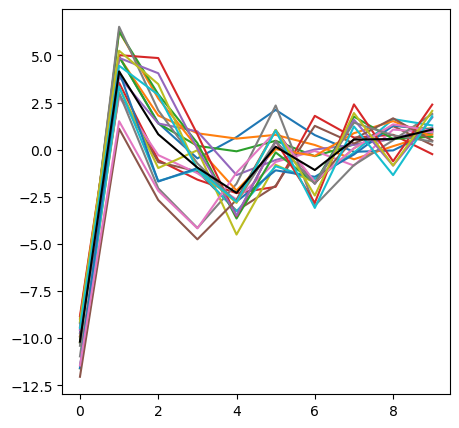

In [157]:
r.plot_beech_spectra(20)

In [158]:
r.target_spectra

array([-10.18275826,   4.15280882,   0.81672625,  -0.94967057,
        -2.29091802,   0.1581802 ,  -1.0792063 ,   0.53744247,
         0.56430044,   1.06867822])

### MTMF

In [139]:
class MTMF():
    # code based on spectral package
    # y={(mu_t-mu_b)^TSigma^{-1}(x-mu_b)}/{(mu_t-mu_b)^TSigma^{-1}(mu_t-mu_b)}
    def __init__(self,endmembers_object):
        self.target_spectra = endmembers_object.target_spectra # array of spectra
        self.mean_target_spectra = np.mean(endmembers_object.target_spectra,axis=0)
        self.mnf = endmembers_object.mnf
        self.mtmf = None

    def make_2d_input_data(self,x):
        x_2d = rearrange(x,'c h w -> (h w) c')
        x_dropna = x_2d[~np.isnan(x_2d).any(axis=1)]  # Remove rows with NaNs
        
        # get indices of dropped nas to replace them later
        na_indices = np.where(np.isnan(x_2d))
        row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

        return x_2d, x_dropna, row_indices

    def replace_na_and_reshape(self,data_2d,final_data,indices):
    # replace nans that were dropped earlier
        output = np.full((data_2d.shape[0]), np.nan)  # create array of correct shape

        # Fill in the rows that were not NaN
        non_nan_indices = np.setdiff1d(np.arange(data_2d.shape[0]), indices)  # get indices that don't have na values
        output[non_nan_indices] = final_data

        shape= self.mnf.shape
        r = output.reshape((shape[1],shape[2]) + (-1,)).squeeze()

        # create data array with geographic coordinates
        return xr.DataArray(r, coords={'y': self.mnf.y, 'x': self.mnf.x},dims=['y','x'])
    

    def run_mtmf(self,mean=True,spectrum_index=None):
        # Target spectral signature 
        if mean is True:
            target = self.mean_target_spectra  
        else:
            target = self.target_spectra[spectrum_index]
        # background mean 
        u_b = np.nanmean(self.mnf.values, axis=(1, 2))  
        # difference between target and background mean
        d_tb = (target- u_b)

        # Calculate the covariance matrix of the background
        # reshape mnf data from 3d to 2d
        mnf_2d, mnf_dropna, na_indices = self.make_2d_input_data(self.mnf.values) 
        C = np.cov(mnf_dropna, rowvar=False)  # Covariance matrix
        # Calculate the inverse of the covariance matrix
        C1 = np.linalg.inv(C)

        # Normalization coefficient (inverse of  squared Mahalanobis distance
        # between u_t and u_b)
        coef = 1.0 / d_tb @ C1 @ d_tb

        # 2d array input
        X = mnf_dropna
        A = (coef * d_tb) @ C1 #transform method 
        Y = (A @ X.T).T

        out = self.replace_na_and_reshape(data_2d=mnf_2d,final_data=Y,indices=na_indices)

        self.mtmf = out




(10, 2101, 1551)

In [140]:
# code based on spectral package
# y={(mu_t-mu_b)^TSigma^{-1}(x-mu_b)}/{(mu_t-mu_b)^TSigma^{-1}(mu_t-mu_b)}

def replace_na_and_reshape(data_2d,data_3d,final_data,indices):
    # replace nans that were dropped earlier
    output = np.full((data_2d.shape[0]), np.nan)  # create array of correct shape

    # Fill in the rows that were not NaN
    non_nan_indices = np.setdiff1d(np.arange(data_2d.shape[0]), indices)  # get indices that don't have na values
    output[non_nan_indices] = final_data

    shape= data_3d.shape
    r = output.reshape((shape[1],shape[2]) + (-1,)).squeeze()

    # create data array with geographic coordinates
    return xr.DataArray(r, coords={'y': s.y, 'x': s.x},dims=['y','x'])



In [137]:
np.nanmean(w.mnf, axis=(1, 2)).shape

(10,)

In [159]:
# Target spectral signature 
target = r.target_spectra
# background mean 
u_b = np.nanmean(w.mnf, axis=(1, 2))  
# difference between target and background mean
d_tb = (target- u_b)

# Calculate the covariance matrix of the background
# reshape mnf data from 3d to 2d
mnf_2d, mnf_dropna, na_indices = make_2d_input_data(w.mnf) 
C = np.cov(mnf_dropna, rowvar=False)  # Covariance matrix
# Calculate the inverse of the covariance matrix
C1 = np.linalg.inv(C)

 # Normalization coefficient (inverse of  squared Mahalanobis distance
# between u_t and u_b)
coef = 1.0 / d_tb @ C1 @ d_tb

# 2d array input
X = mnf_dropna
A = (coef * d_tb) @ C1 #transform method 
Y = (A @ X.T).T

out = replace_na_and_reshape(data_2d=mnf_2d,data_3d=w.mnf,final_data=Y,indices=na_indices)

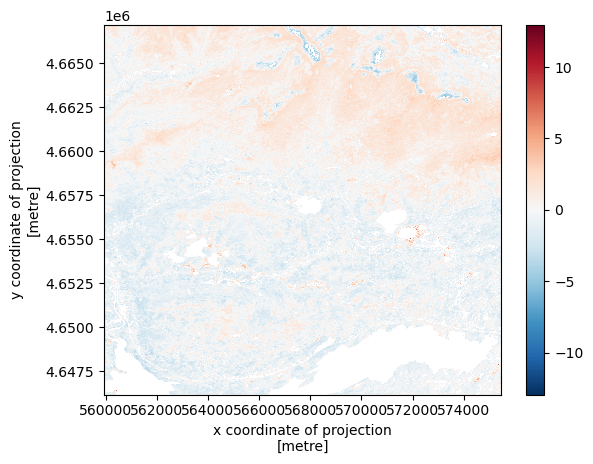

In [160]:
out.plot()

In [151]:
out.to_netcdf(root / 'output' / 'catskills' / 'ashoken_mtmf.nc')

In [ ]:
np.outer(out,p_mean).shape

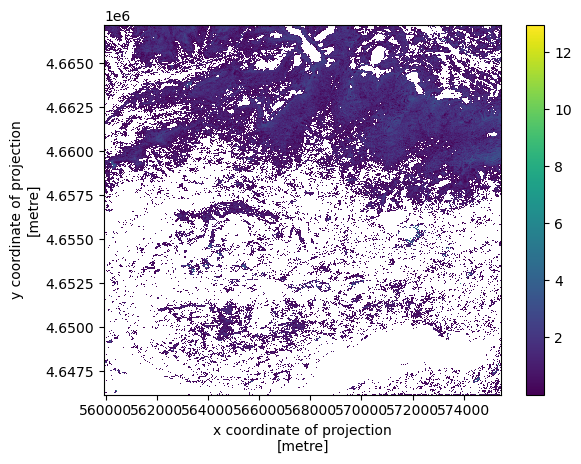

In [161]:
# all values less than 0 set to 0, values greater than 1 set to 1
# t1 = out.where((out<1),1)
# t2 = t1.where((out>0),np.nan)
#t2.plot()
#t2.to_netcdf(root / 'output' / 'BART' / 'bartlett_mtmf_new_clamped0to1.nc')

t = out.where((out>0),np.nan)
t.plot()
#t.to_netcdf(root / 'output' / 'catskills' / 'ashoken_mtmf_greaterthan0.nc')

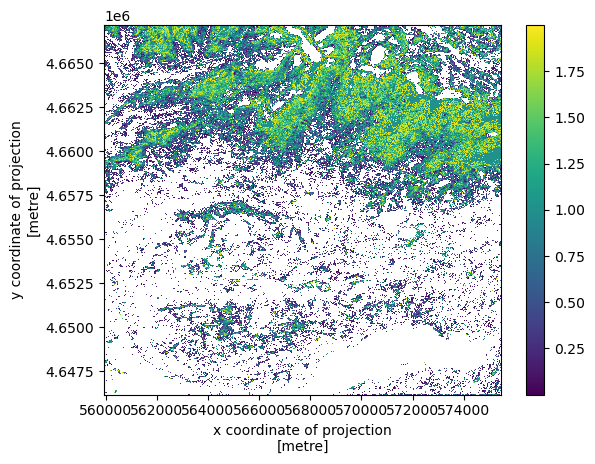

In [162]:
t1 = out.where((out<2),1)
t2 = t1.where((out>0),np.nan)
t2.plot()

In [164]:
t2.to_netcdf(root / 'output' / 'catskills' / 'ashoken_mtmf_0to2_new.nc')

In [ ]:
ba = xr.open_dataset(root / 'output' / 'BART' / 'percent_basal_area_BART.nc')
ba = ba['percent_beech_basal_area']

In [95]:
ba_2d = rearrange(ba.to_numpy(),'h w -> (h w)')
t2_2d = rearrange(out.to_numpy(),'h w -> (h w)')

combine = np.vstack((ba_2d,t2_2d)).T

df_dropna = combine[~np.isnan(combine).any(axis=1)]

In [97]:
np.corrcoef(df_dropna,rowvar=False)

array([[1.        , 0.38917399],
       [0.38917399, 1.        ]])

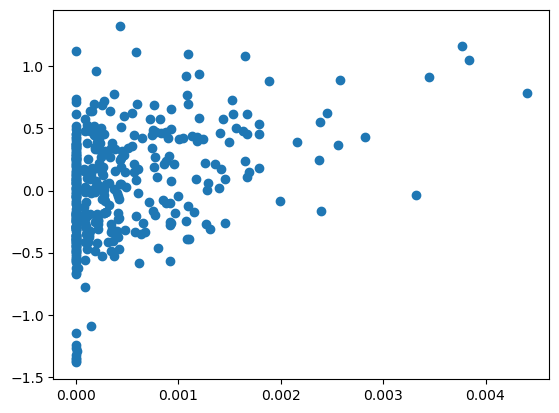

In [96]:
plt.scatter(df_dropna[:,0],df_dropna[:,1])

In [ ]:
# Precompute reusable terms
#mu_diff = mu_t - mu_b  # Difference between target and background mean
# numerator_constant = mu_diff.T @ Sigma_inv  # Precompute (mu_t - mu_b)^T Sigma^-1
# denominator = mu_diff.T @ Sigma_inv @ mu_diff  # Precompute denominator

# Initialize output array for matched filtering scores
#mf_scores = np.zeros((reshaped_data.shape[0], reshaped_data.shape[1]))


# Vectorized implementation
x_diff = reshaped_data - u_b  # Subtract background mean from all pixels (pixels x bands)
numerator = x_diff @ C1 @ d_tb  # Compute the numerator for all pixels
denominator = d_tb.T @ C1 @ d_tb  # Precompute denominator
mf_scores_vectorized = numerator.reshape(reshaped_data.shape[0], reshaped_data.shape[1]) / denominator  # Reshape to image dimensions

In [ ]:

# mtmf code based on spectral package



def cov(M):
    """
    Compute the sample covariance matrix of a 2D matrix.

    Parameters:
      M: `numpy array`
        2d matrix of HSI data (N x p)

    Returns: `numpy array`
        sample covariance matrix
    """
    N = M.shape[0]
    u = M.mean(axis=0)
    M = M - np.kron(np.ones((N, 1)), u)
    C = np.dot(M.T, M) / (N-1)
    return C



def whiten(M):
    """
    Whitens a HSI cube. Use the noise covariance matrix to decorrelate
    and rescale the noise in the data (noise whitening).
    Results in transformed data in which the noise has unit variance
    and no band-to-band correlations.

    Parameters:
        M: `numpy array`
            2d matrix of HSI data (N x p).

    Returns: `numpy array`
        Whitened HSI data (N x p).

    Reference:
        Krizhevsky, Alex, Learning Multiple Layers of Features from
        Tiny Images, MSc thesis, University of Toronto, 2009.
        See Appendix A.
    """
    sigma = util.cov(M)
    U,S,V = np.linalg.svd(sigma)
    S_1_2 = S**(-0.5)
    S = np.diag(S_1_2.T)
    Aw = np.dot(V, np.dot(S, V.T))
    return np.dot(M, Aw)


class Whiten(object):
    """Whiten the cube."""

    def __init__(self):
        self.dM = None

    @ApplyInputValidation('Whiten')
    def apply(self, M):
        """
        Whitens a HSI cube. Use the noise covariance matrix to decorrelate
        and rescale the noise in the data (noise whitening).
        Results in transformed data in which the noise has unit variance
        and no band-to-band correlations.

        Parameters:
            M: `numpy array`
              A HSI cube (m x n x p).

        Returns: `numpy array`
              A whitened HSI cube (m x n x p).
        """
        h, w, numBands = M.shape
        M = np.reshape(M, (w*h, numBands))
        dM = dnoise.whiten(M)
        self.dM = np.reshape(dM, (h, w, numBands))
        return self.dM

    def get(self):
        """
        Returns: `numpy array`
            The whitened HSI cube (m x n x p).
        """
        return self.dM


class MNF(object):
    """Transform a HSI cube."""

    def __init__(self):
        self.mnf = None
        self.transform = None
        self.wdata = None # temp

    @ApplyInputValidation('MNF')
    def apply(self, M):
        """
        A linear transformation that consists of a noise whitening step
        and one PCA rotation.

        This process is designed to
            * determine the inherent dimensionality of image data,
            * segregate noise in the data,
            * allow efficient elimination and/or reduction of noise, and
            * reduce the computational requirements for subsequent processing.

        Parameters:
            M: `numpy array`
              A HSI cube (m x n x p).

        Returns: `numpy array`
              A MNF transformed cube (m x n x p).

        References:
          C-I Change and Q Du, "Interference and Noise-Adjusted Principal
          Components Analysis," IEEE TGRS, Vol 36, No 5, September 1999.
        """
        from sklearn.decomposition import PCA
        w = Whiten()
        wdata = w.apply(M)
        self.wdata = wdata #temp
        h, w, numBands = wdata.shape
        X = np.reshape(wdata, (w*h, numBands))
        self.transform = PCA()
        mnf = self.transform.fit_transform(X)
        self.mnf = np.reshape(mnf, (h, w, numBands))
        return self.mnf

In [ ]:
# target vector component = scalar product of MF value array and target vector

# Example scalar array (C, H, W)
scalar_array = np.random.rand(3, 4, 4)  # Example shape (C=3, H=4, W=4)

# Example vector of size (C,)
vector = np.array([2, 3, 4])  # One scalar per channel

# Reshape vector to (C, 1, 1) for broadcasting
result = scalar_array * vector[:, np.newaxis, np.newaxis]

print("Result shape:", result.shape)  # Should be (3, 4, 4)

In [ ]:
# compute eigenvalues

def compute_mnf_eigenvalues(mnf_array):
    """
    Compute the eigenvalues of an MNF-transformed array.

    Parameters:
        mnf_array (numpy array): MNF data of shape (C, H, W)
    
    Returns:
        numpy array: Eigenvalues of the MNF transformation (size C)
    """
    C, H, W = mnf_array.shape  # Get dimensions
    reshaped_data = mnf_array.reshape(C, H * W)  # Reshape to (C, N) where N = H * W

    # Compute the covariance matrix (C x C)
    covariance_matrix = np.cov(reshaped_data)

    # Compute eigenvalues of the covariance matrix
    eigenvalues, _ = np.linalg.eigh(covariance_matrix)

    return eigenvalues

# interpolated vector of eigenvalues

def compute_e_bar(e_MNF, MF_i, e_n):
    """
    Compute ē_i using the given equation.

    Parameters:
        e_MNF (numpy array): MNF eigenvalue vector
        MF_i (numpy array or scalar): Scaling factor for pixel i
        e_n (numpy array): Noise eigenvalue vector (vector of ones)

    Returns:
        numpy array: Computed ē_i values
    """
    sqrt_e_MNF = np.sqrt(e_MNF)  # Compute square root of MNF eigenvalues
    term = sqrt_e_MNF - MF_i * (sqrt_e_MNF - e_n)  # Compute the inner term
    e_bar = term ** 2  # Square the result
    return e_bar

In [ ]:
def compute_infeasibility(S_i, C_i, e_i):
    """
    Compute the infeasibility value I_i for a given pixel.

    Parameters:
        S_i (numpy array): MNF spectra for pixel i (vector)
        C_i (numpy array): Reference/comparison spectra for pixel i (vector)
        e_i (numpy array): Eigenvalue vector for pixel i (vector)
    
    Returns:
        float: Computed infeasibility value I_i
    """
    numerator = np.linalg.norm(S_i - C_i)  # Compute Euclidean norm of (S_i - C_i)
    denominator = np.linalg.norm(e_i)  # Compute Euclidean norm of e_i

    if denominator == 0:
        return np.inf  # Avoid division by zero by returning infinity

    return numerator / denominator